# Using Naive Bayes to Classify Text
This project will focus on doing sentiment analysis and classify a body of text as positive or negative. I wanted to do this project to practice using the naive bayes classifier which is one of my favourite machine learning models

For this project we will be using a dataset of movie reviews from IMDB

Retrived from: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter


# Pull data from csv dataset and split into 80% training and 20% test data
df = pd.read_csv (r'data/IMDB Dataset.csv')
train, test = train_test_split(df, test_size=0.2)

# Size of data
train.shape, test.shape

((40000, 2), (10000, 2))

50,000 movie reviews is a pretty large dataset for my purposes so I'm only going to use about half the dataset for this project. We will reduce it down to 20,000 for training and 2,000 for testing.

In [102]:
# Take random sample of training and test sets
train = train.sample(n=20000)
test = test.sample(n=2500)

train.shape, test.shape

((20000, 2), (2500, 2))

Now let's take a look at the split between positive and negative reviews within our dataset as well as a word cloud displaying the most commonly used words in the reviews.

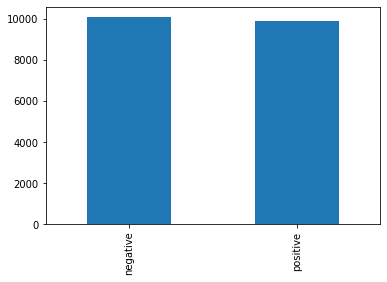

In [103]:
sentiment = train['sentiment'].value_counts()
sentiment.plot.bar(align='center')

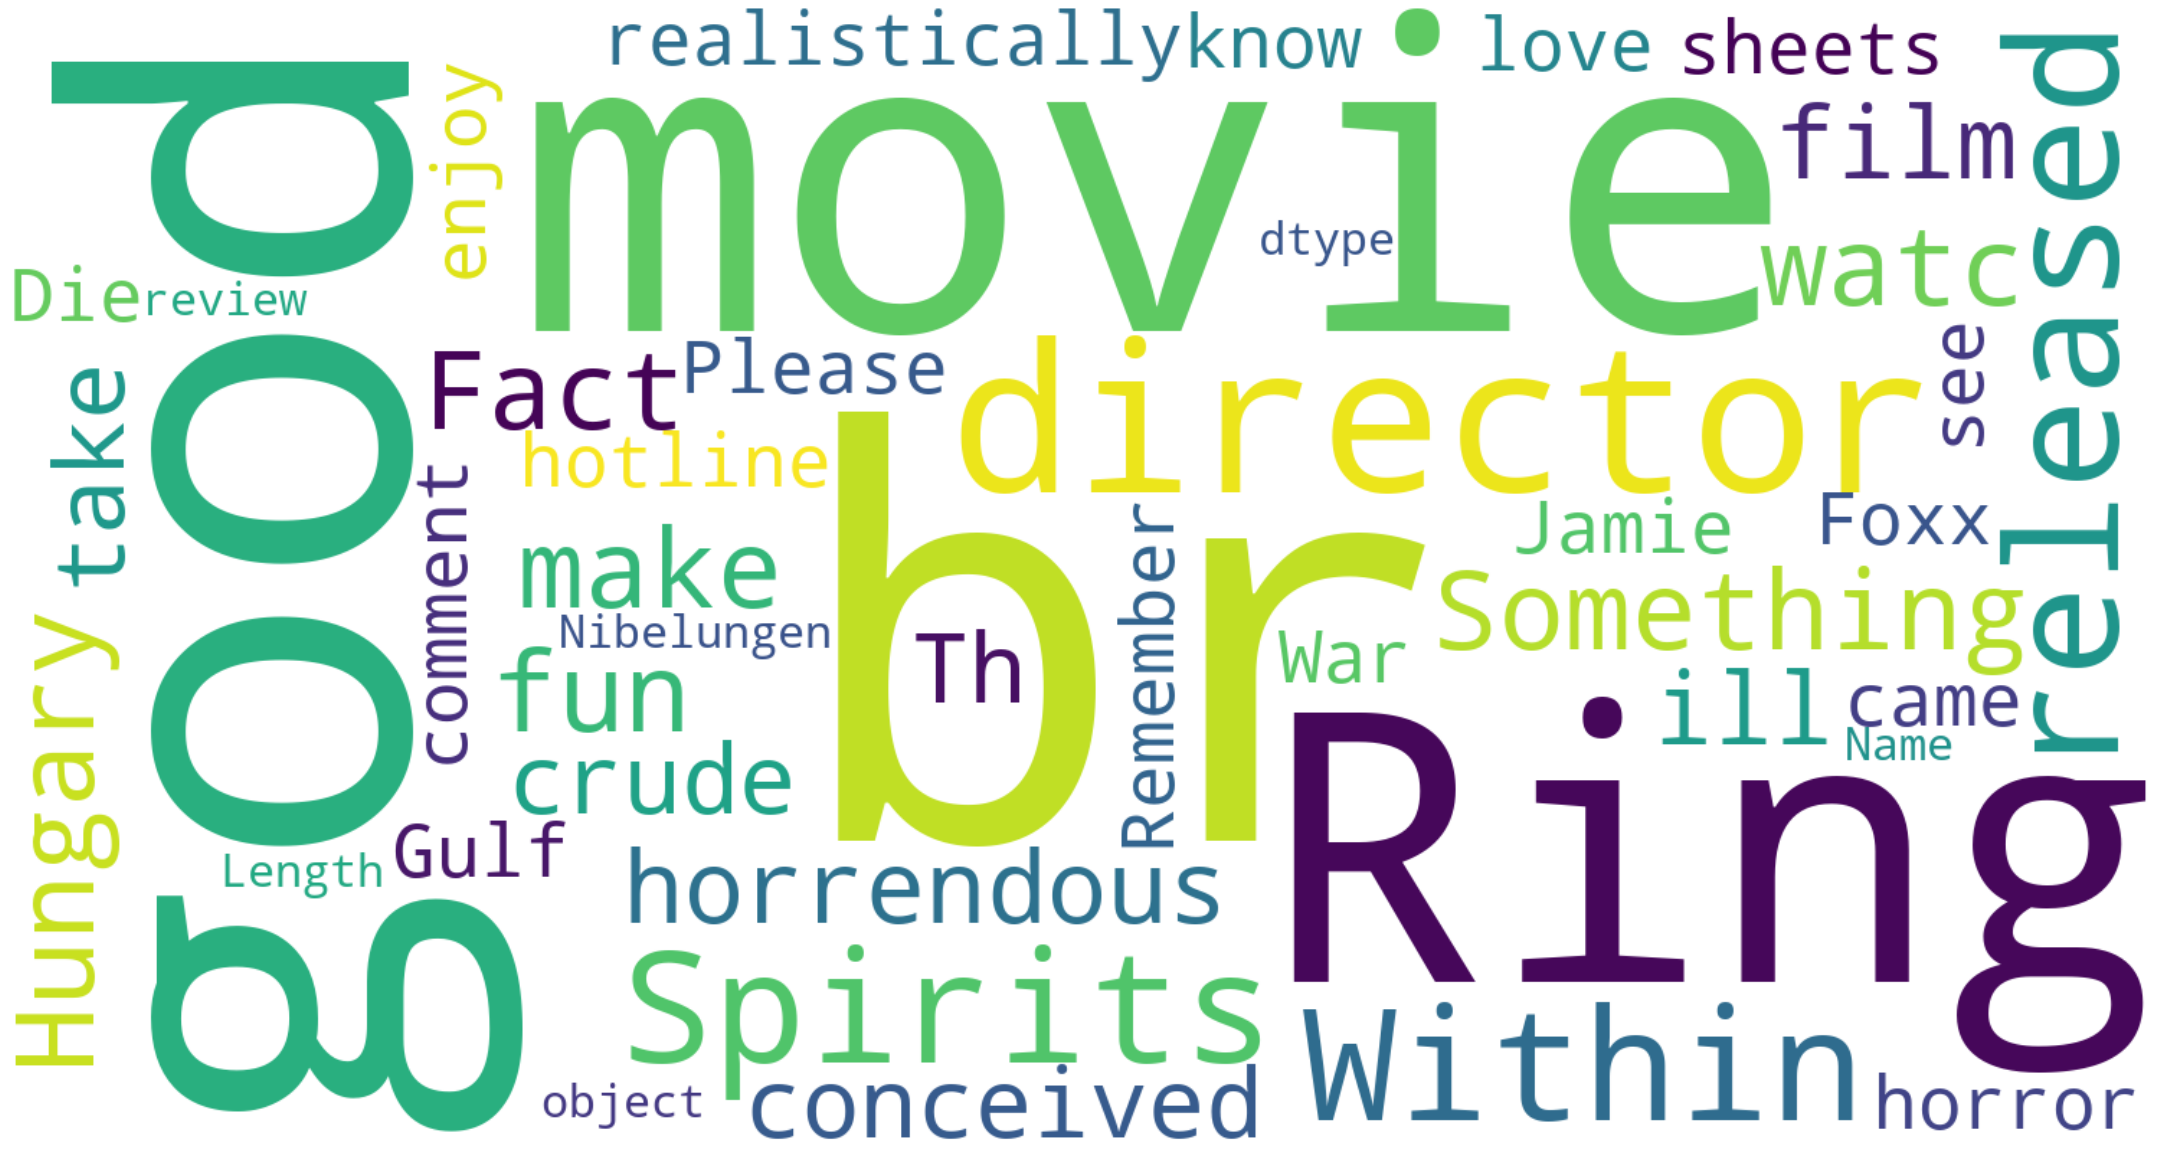

In [104]:
# Build a word cloud with the most common words in all the reviews excluding the stopwords like "the", "this", "to", etc.
text = train['review']
wordcloud = WordCloud(
    width = 1500,
    height = 800,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (30, 25),
    facecolor = 'white',
    edgecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Currently our dataset contains a bunch of unwanted characters which we can see below so we will have to do some data cleaning to get rid of things like commas, dashes, and html tags like "<br /"

In [106]:
# Sample review before cleaning it up
train.values[0][0]

"When The Spirits Within was released, all you heard from Final Fantasy fans was how awful the movie was because it didn't seem like Final Fantasy. This is a different story, for better or worse. The familiar settings, characters, music, story, and over the top action scenes should thrill fans of the original game. The problem is that it just isn't a good movie in its own right.<br /><br />The direction during the fight scenes is often sloppy, switching camera angles ridiculously fast in an attempt to make the action seem more frenetic, but only serving to make the scenes look jumbled and confusing.<br /><br />The CG itself is exceptional, but I can't say it's the best I've ever seen since Spirits Within had much more detail on the characters, although I must admit that Advent Children's characters moved much more naturally.<br /><br />The plot is virtually a black hole. It's a giant deus ex machina designed solely to bring Sephiroth back for one last fight. Old characters reappear, bu

In [107]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_text(text):
    text = REPLACE_NO_SPACE.sub("", text.lower())
    text = REPLACE_WITH_SPACE.sub(" ", text)
    
    return text


for i in range(0, len(train.values)):
    train.values[i][0] = preprocess_text(train.values[i][0])

# Repeat process for test set
for i in range(0, len(test.values)):
    test.values[i][0] = preprocess_text(test.values[i][0])
    
# Print cleaned version of above review to confirm that it worked
train.values[0][0]

'when the spirits within was released all you heard from final fantasy fans was how awful the movie was because it didnt seem like final fantasy this is a different story for better or worse the familiar settings characters music story and over the top action scenes should thrill fans of the original game the problem is that it just isnt a good movie in its own right the direction during the fight scenes is often sloppy switching camera angles ridiculously fast in an attempt to make the action seem more frenetic but only serving to make the scenes look jumbled and confusing the cg itself is exceptional but i cant say its the best ive ever seen since spirits within had much more detail on the characters although i must admit that advent childrens characters moved much more naturally the plot is virtually a black hole its a giant deus ex machina designed solely to bring sephiroth back for one last fight old characters reappear but serve no real purpose other than to please fans character

In order to classify text using Naive Bayes, we are going to have to split up each word in the reviews and use the different words as features in the model. This will allow us to associate certain words with negative or positive reviews and futhermore allow us to classify new text as positive and negative. To simplify things, we are going to only look at the top 5000 most common words among the reviews. This should be more than enough descriptive features for our purposes.

In [108]:
import nltk
from nltk.corpus import stopwords
# Download stopwords and convert to set to increase efficiency
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

# Combine reviews into one long string
def combine_text(text_list):
    text = " ".join([t[0] for t in text_list])
    return text
    
all_words_string = combine_text(train.values)


all_words_list = all_words_string.split(' ') 
word_frequency = nltk.FreqDist(all_words_list)

# Get top 5000 most common words in all reviews then remove stop words
word_features = list(word_frequency.keys())[:5000]
filtered_word_features = [w for w in word_features if w not in stopwords]


[nltk_data] Downloading package stopwords to C:\Users\Luca
[nltk_data]     Imbrogno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next we want to convert our training and testing sets into a feature set that the NLTK Naive Bayes Classifier can handle. This involves going through each review and checking which of the top 5000 words are used in that review.

In [109]:
# Given a review, return a dictionary containing the top 5000 words with the key being a True or False value representing
# whether or not that word is used in the review
def get_features(review):
    word_list = set(review)
    features = {}
    
    for word in word_features:
        features[word] = (word in word_list)
    
    return features

# Create feature set for training data using function above
train_feature_set = []
for review in train.values:
    train_text_list = review[0].split(' ')
    train_sentiment = review[1]
    
    train_feature_set.append((get_features(train_text_list), train_sentiment))

# Create feature set for testing data
test_feature_set = []
for review in test.values:
    test_text_list = review[0].split(' ')
    test_sentiment = review[1]
    
    test_feature_set.append((get_features(test_text_list), test_sentiment))

   

Finally we can train our model using NLTK's Naive Bayes Classifier. We will also show the accuracy of the model using the test set and also display a few of the most informative words used during our classification.

In [112]:
classifier = nltk.NaiveBayesClassifier.train(train_feature_set)
print("Naive Bayes Algo Accuracy: {:.2f}%".format(nltk.classify.accuracy(classifier, test_feature_set)*100))
classifier.show_most_informative_features(10)

Naive Bayes Algo Accuracy: 83.68%
Most Informative Features
               awfulness = True           negati : positi =     21.3 : 1.0
                    edie = True           positi : negati =     16.0 : 1.0
                timeless = True           positi : negati =     12.7 : 1.0
                flawless = True           positi : negati =     12.4 : 1.0
              redeemable = True           negati : positi =     12.1 : 1.0
                   waste = True           negati : positi =     12.1 : 1.0
                    dirk = True           positi : negati =     11.9 : 1.0
               atrocious = True           negati : positi =     11.3 : 1.0
               numbingly = True           negati : positi =     11.2 : 1.0
             unwatchable = True           negati : positi =     11.1 : 1.0
